In [1]:
import torch
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
from modules.pipeline_model import ConvAutoencoder, MLPClassifier, perform_kmeans, compute_clustering_metrics, check_overfitting
from modules.pipeline_train import get_dataloaders, train_autoencoder, extract_latents

In [2]:
data_root = Path("data/splits")
train_dir = data_root / "train"
val_dir = data_root / "val"
test_dir = data_root / "test"

output_dir = Path("ae_pipeline")
output_dir.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
latent_dim = 128


In [3]:
train_loader, _ = get_dataloaders(train_dir, batch_size=batch_size, val_split=0.0)
val_loader, _ = get_dataloaders(val_dir, batch_size=batch_size, val_split=0.0)

model = ConvAutoencoder(latent_dim=latent_dim)
model, history = train_autoencoder(model, train_loader, val_loader, device)

Epoch 1/30 [Val]: 100%|██████████| 26/26 [01:27<00:00,  3.35s/it]


Epoch 1: Train Loss = 0.8983, Val Loss = 0.8311


Epoch 2/30 [Val]: 100%|██████████| 26/26 [01:33<00:00,  3.58s/it]


Epoch 2: Train Loss = 0.8657, Val Loss = 0.8235


Epoch 3/30 [Val]: 100%|██████████| 26/26 [00:59<00:00,  2.28s/it]


Epoch 3: Train Loss = 0.8568, Val Loss = 0.8142


Epoch 4/30 [Val]: 100%|██████████| 26/26 [01:21<00:00,  3.14s/it]


Epoch 4: Train Loss = 0.8414, Val Loss = 0.7991


Epoch 5/30 [Val]: 100%|██████████| 26/26 [01:18<00:00,  3.02s/it]


Epoch 5: Train Loss = 0.8328, Val Loss = 0.7961


Epoch 6/30 [Val]: 100%|██████████| 26/26 [01:03<00:00,  2.45s/it]


Epoch 6: Train Loss = 0.8289, Val Loss = 0.7942


Epoch 7/30 [Val]: 100%|██████████| 26/26 [01:09<00:00,  2.66s/it]


Epoch 7: Train Loss = 0.8254, Val Loss = 0.7916


Epoch 8/30 [Val]: 100%|██████████| 26/26 [01:06<00:00,  2.55s/it]


Epoch 8: Train Loss = 0.8229, Val Loss = 0.7907


Epoch 9/30 [Val]: 100%|██████████| 26/26 [01:06<00:00,  2.54s/it]


Epoch 9: Train Loss = 0.8202, Val Loss = 0.7901


Epoch 10/30 [Val]: 100%|██████████| 26/26 [01:03<00:00,  2.43s/it]


Epoch 10: Train Loss = 0.8179, Val Loss = 0.7907


Epoch 11/30 [Val]: 100%|██████████| 26/26 [01:02<00:00,  2.40s/it]


Epoch 11: Train Loss = 0.8161, Val Loss = 0.7901


Epoch 12/30 [Val]: 100%|██████████| 26/26 [01:02<00:00,  2.39s/it]


Epoch 12: Train Loss = 0.8139, Val Loss = 0.7908


Epoch 13/30 [Val]: 100%|██████████| 26/26 [01:07<00:00,  2.59s/it]


Epoch 13: Train Loss = 0.8114, Val Loss = 0.8043


Epoch 14/30 [Val]: 100%|██████████| 26/26 [01:08<00:00,  2.64s/it]

Epoch 14: Train Loss = 0.8199, Val Loss = 0.7963
Early stopping triggered at epoch 14


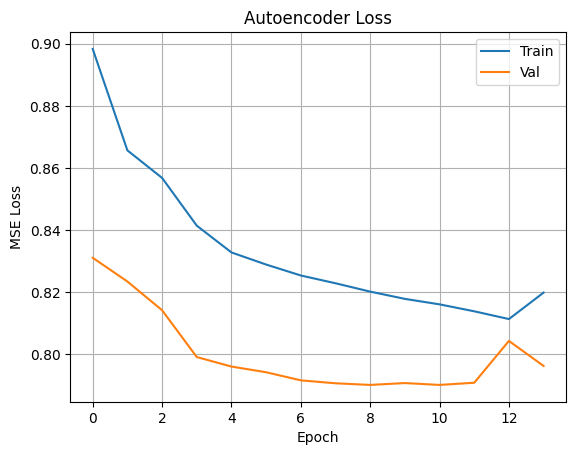

In [4]:
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Val")
plt.title("Autoencoder Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.savefig(output_dir / "ae_loss_curve.png")
plt.show()

In [5]:
with open(output_dir / "ae_loss_history.json", "w") as f:
    json.dump(history, f)

torch.save(model.state_dict(), output_dir / "autoencoder.pt")

In [18]:
from torch.utils.data import ConcatDataset
from modules.pipeline_train import ImageFolderWithPaths, get_transforms

# Create datasets for each split
train_ds = ImageFolderWithPaths(train_dir, transform=get_transforms())
val_ds = ImageFolderWithPaths(val_dir, transform=get_transforms())

# Concatenate all datasets
all_ds = ConcatDataset([train_ds, val_ds])
all_loader = torch.utils.data.DataLoader(all_ds, batch_size=batch_size, shuffle=False)

In [19]:
latents, paths = extract_latents(model, all_loader, device)

np.save(output_dir / "latents.npy", latents)
with open(output_dir / "paths.txt", "w") as f:
    for p in paths:
        f.write(f"{p}\n")


Extracting Latents: 100%|██████████| 130/130 [06:42<00:00,  3.09s/it]


(4134, 128) (4134,) (4134, 2)


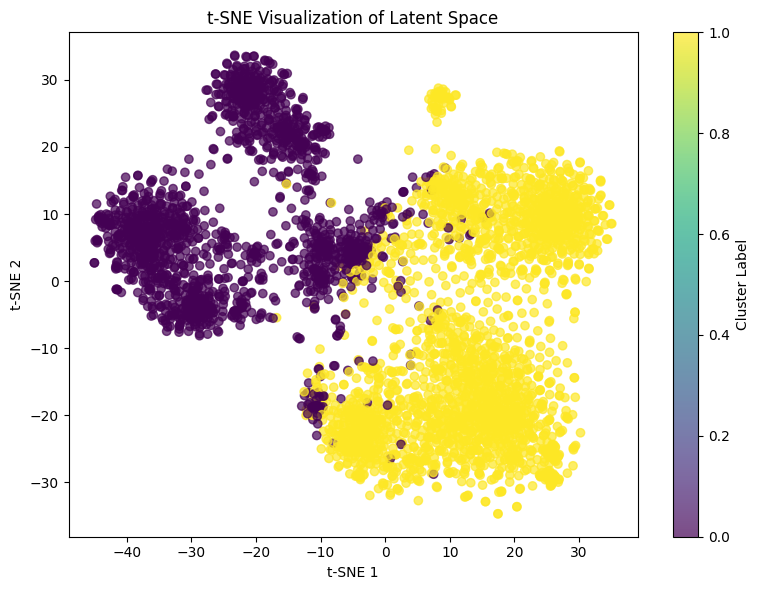

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print(latents.shape, labels.shape, latents_2d.shape)

# Run t-SNE on the latent vectors
tsne = TSNE(n_components=2, random_state=42)
latents_2d = tsne.fit_transform(latents)

# Plot t-SNE with cluster labels
plt.figure(figsize=(8,6))
scatter = plt.scatter(latents_2d[:,0], latents_2d[:,1], c=labels, cmap='viridis', alpha=0.7)
plt.title("t-SNE Visualization of Latent Space")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, label='Cluster Label')
plt.tight_layout()
# plt.savefig(output_dir / "tsne_latent_clusters.png")
plt.show()


In [22]:
kmeans, labels = perform_kmeans(latents, n_clusters=2)
np.save(output_dir / "kmeans_labels.npy", labels)

metrics = compute_clustering_metrics(latents, labels)

metrics = {k: float(v) if isinstance(v, np.generic) else v for k, v in metrics.items()}
with open(output_dir / "clustering_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Clustering metrics:")
print(json.dumps(metrics, indent=2))

Clustering metrics:
{
  "silhouette": 0.1185840368270874,
  "ARI": 1.0,
  "NMI": 1.0,
  "Calinski-Harabasz": 452.9395446777344,
  "Davies-Bouldin": 2.8400236877235123
}


In [3]:
latents = np.load(output_dir / "latents.npy")
labels = np.load(output_dir / "kmeans_labels.npy")

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X_train, X_val, y_train, y_val = train_test_split(latents, labels, test_size=0.2, random_state=42)

tensor_train = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
tensor_val = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_dl = DataLoader(tensor_train, batch_size=32, shuffle=True)
val_dl = DataLoader(tensor_val, batch_size=32)

mlp = MLPClassifier(input_dim=latent_dim, num_classes=2, dropout_p=0.7).to(`device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e-3)  # Add weight decay
criterion = torch.nn.CrossEntropyLoss()

train_loss, val_loss = [], []
best_val_loss = float('inf')
patience = 2
epochs_no_improve = 0
num_epochs = 20

for epoch in range(num_epochs):
    mlp.train()
    t_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = mlp(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        t_loss += loss.item() * xb.size(0)
    t_loss /= len(train_dl.dataset)
    train_loss.append(t_loss)

    mlp.eval()
    v_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = mlp(xb)
            loss = criterion(pred, yb)
            v_loss += loss.item() * xb.size(0)
    v_loss /= len(val_dl.dataset)
    val_loss.append(v_loss)

    print(f"Epoch {epoch+1}: MLP Train Loss = {t_loss:.4f}, Val Loss = {v_loss:.4f}")

    # Early stopping
    if v_loss < best_val_loss:
        best_val_loss = v_loss
        epochs_no_improve = 0
        torch.save(mlp.state_dict(), output_dir / "mlp_classifier.pt")  # Save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

Epoch 1: MLP Train Loss = 0.2609, Val Loss = 0.0556
Epoch 2: MLP Train Loss = 0.0842, Val Loss = 0.0369
Epoch 3: MLP Train Loss = 0.0549, Val Loss = 0.0326
Epoch 4: MLP Train Loss = 0.0421, Val Loss = 0.0268
Epoch 5: MLP Train Loss = 0.0362, Val Loss = 0.0245
Epoch 6: MLP Train Loss = 0.0322, Val Loss = 0.0260
Epoch 7: MLP Train Loss = 0.0226, Val Loss = 0.0237
Epoch 8: MLP Train Loss = 0.0231, Val Loss = 0.0219
Epoch 9: MLP Train Loss = 0.0238, Val Loss = 0.0214
Epoch 10: MLP Train Loss = 0.0188, Val Loss = 0.0226
Epoch 11: MLP Train Loss = 0.0219, Val Loss = 0.0222
Early stopping triggered.


In [13]:
is_overfit, gap = check_overfitting(train_loss[-1], val_loss[-1])
print(f"Generalization Gap: {gap:.4f} | Overfitting: {is_overfit}")

Generalization Gap: 0.0176 | Overfitting: False


In [14]:
torch.save(mlp.state_dict(), output_dir / "mlp_classifier.pt")
with open(output_dir / "mlp_loss_history.json", "w") as f:
    json.dump({"train_loss": train_loss, "val_loss": val_loss}, f)

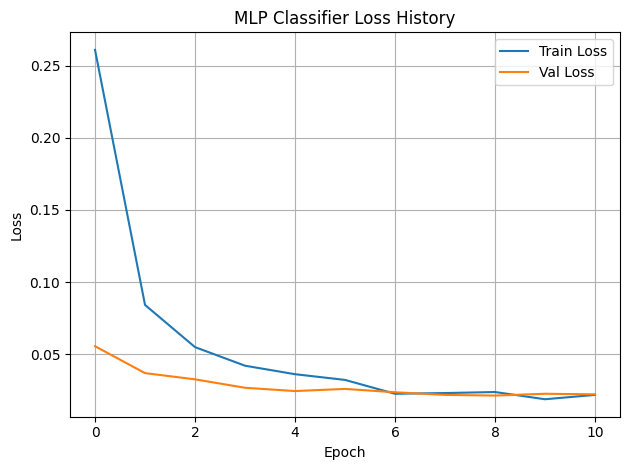

In [15]:
# Visualize MLP train/val loss history
import json
import matplotlib.pyplot as plt

with open(output_dir / "mlp_loss_history.json", "r") as f:
    mlp_history = json.load(f)

plt.plot(mlp_history["train_loss"], label="Train Loss")
plt.plot(mlp_history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP Classifier Loss History")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Utility

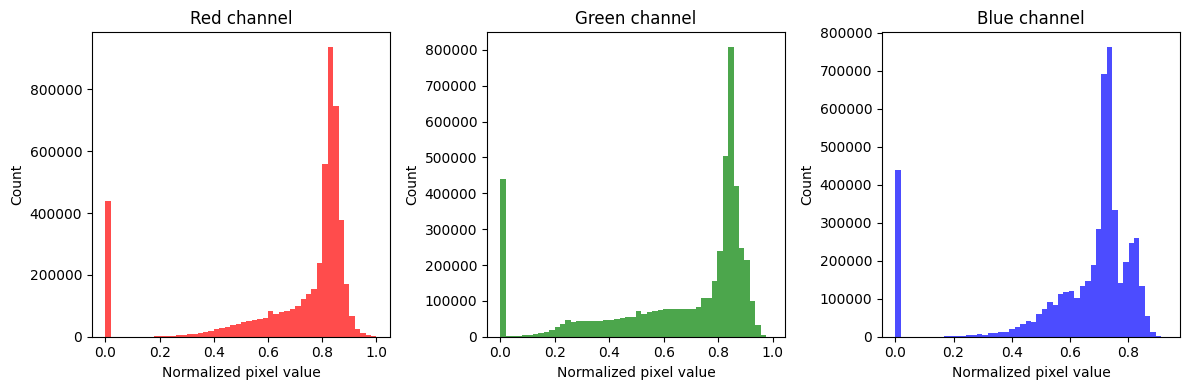

Mean (R,G,B): [0.70491495 0.65667014 0.63810917]
Std (R,G,B): [0.24834319 0.27763783 0.22302949]


In [8]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import glob

# Inspect a few images from train_dir
image_paths = list((train_dir / "unlabeled").glob("*.png"))[:100]
all_pixels = []

for img_path in image_paths:
    img = Image.open(img_path).convert("RGB")
    arr = np.array(img) / 255.0  # scale to [0, 1] for visualization
    all_pixels.append(arr.reshape(-1, 3))

all_pixels = np.concatenate(all_pixels, axis=0)

plt.figure(figsize=(12,4))
for i, color in enumerate(['Red', 'Green', 'Blue']):
    plt.subplot(1,3,i+1)
    plt.hist(all_pixels[:,i], bins=50, color=color.lower(), alpha=0.7)
    plt.title(f'{color} channel')
    plt.xlabel('Normalized pixel value')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

print("Mean (R,G,B):", all_pixels.mean(axis=0))
print("Std (R,G,B):", all_pixels.std(axis=0))

In [ ]:
from pathlib import Path
import shutil

for split in ["train", "val", "test"]:
    split_dir = Path(f"data/splits/{split}")
    unlabeled_dir = split_dir / "unlabeled"
    unlabeled_dir.mkdir(exist_ok=True)

    for img in split_dir.glob("*.png"):
        shutil.move(str(img), unlabeled_dir / img.name)


In [20]:
clinical_loader, _ = get_dataloaders(test_dir, batch_size=32, val_split=0.0)

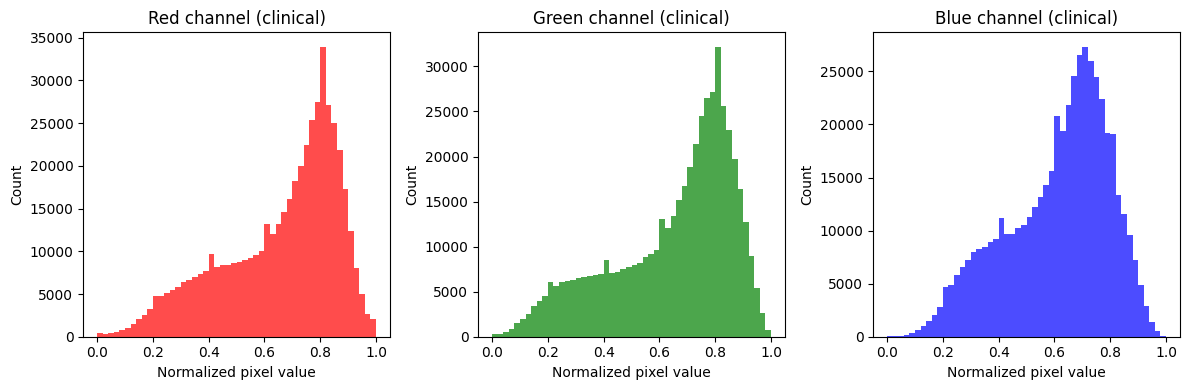

Clinical Mean (R,G,B): [0.65793264 0.64854445 0.61168727]
Clinical Std (R,G,B): [0.20715057 0.21596058 0.18366023]


In [21]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Example: visualize and check stats for clinical images
clinical_image_paths = list((test_dir / "unlabeled").glob("*.png"))[:10]
clinical_pixels = []

for img_path in clinical_image_paths:
    img = Image.open(img_path).convert("RGB")
    arr = np.array(img) / 255.0  # scale to [0, 1]
    clinical_pixels.append(arr.reshape(-1, 3))

clinical_pixels = np.concatenate(clinical_pixels, axis=0)

plt.figure(figsize=(12,4))
for i, color in enumerate(['Red', 'Green', 'Blue']):
    plt.subplot(1,3,i+1)
    plt.hist(clinical_pixels[:,i], bins=50, color=color.lower(), alpha=0.7)
    plt.title(f'{color} channel (clinical)')
    plt.xlabel('Normalized pixel value')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

print("Clinical Mean (R,G,B):", clinical_pixels.mean(axis=0))
print("Clinical Std (R,G,B):", clinical_pixels.std(axis=0))

In [24]:
model = ConvAutoencoder(latent_dim=latent_dim)
model.load_state_dict(torch.load(output_dir / "autoencoder.pt", map_location=device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.to(device)
model.train()  # Important: set to train mode to update BatchNorm stats

with torch.no_grad():
    for x, _, _ in clinical_loader:
        x = x.to(device)
        _ = model(x)  # Forward pass updates BatchNorm running stats

model.eval()  # Set back to eval mode for inference

recon_loss = 0.0
with torch.no_grad():
    for x, _, _ in clinical_loader:
        x = x.to(device)
        x_recon, _ = model(x)
        loss = torch.nn.functional.mse_loss(x_recon, x, reduction='sum')
        recon_loss += loss.item()
recon_loss /= len(clinical_loader.dataset)
print(f"[Clinical Test] AE Reconstruction Loss: {recon_loss:.4f}")

[Clinical Test] AE Reconstruction Loss: 106305.5500


In [ ]:
latents_clinical, paths_clinical = extract_latents(model, clinical_loader, device)

In [ ]:
latents_dibas = np.load(output_dir / "latents.npy")
combined_latents = np.vstack([latents_dibas, latents_clinical])
src_labels = np.array([0] * len(latents_dibas) + [1] * len(latents_clinical))

tsne = TSNE(n_components=2, random_state=42)
proj = tsne.fit_transform(combined_latents)

plt.figure(figsize=(8, 6))
plt.scatter(proj[src_labels==0][:,0], proj[src_labels==0][:,1], s=10, label="DIBaS")
plt.scatter(proj[src_labels==1][:,0], proj[src_labels==1][:,1], s=10, label="Clinical")
plt.title("t-SNE Latent Space: DIBaS vs Clinical")
plt.legend()
plt.grid(True)
plt.savefig(output_dir / "tsne_dibas_vs_clinical.png")
plt.show()

In [ ]:
mlp.eval()
with torch.no_grad():
    logits = mlp(torch.tensor(latents_clinical, dtype=torch.float32).to(device))
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().numpy()

pred_counts = Counter(preds)
print(f"[Clinical Test] MLP Prediction Counts: {pred_counts}")